# Classifying Survival of the Titanic Disaster 

## Introduction: 

##### Background Information:
The RMS Titanic was a British passenger ship that sank in the North Atlantic Ocean after striking an iceberg during its maiden voyage in 1912. There were an estimated 2,224 passengers and crew aboard. Ultimately, over 1,500 died, making it the deadliest sinking of a single ship at the time. 
Despite the tragic nature of the event, the Titanic disaster became a symbol of the chivalry and honor upheld by men at the time, as recorded by the Reagan Library: “Women and children were given first priority for the lifeboats.”

##### Key Questions:
This leads us to two questions, which we hope to answer through this report. Firstly, is the idea that women and children were given priority backed by statistical evidence? Secondly, did wealth differences have an impact on who had priority access to lifeboats? 
We expect that wealthier people, women, and younger people have a higher survival rate than others.

##### About the Dataset:
We obtained the data through Data Science Dojo’s github repository of datasets. Both Data Science Dojo’s website and github repository is cited in our references section. Data Science Dojo is an e-learning program dedicated to teaching students data science, data analytics and other data-related topics.
The dataset they provide includes 891 observations of passengers aboard the Titanic. It also includes many forms of information about passengers. This includes `PassengerId`, `Survived`, `Pclass`, `Name`, `Sex`, `Age`, `SibSp`, `Parch`, `Ticket`, `Fare`, `Cabin`, and `Embarked`. We will not describe each of these in detail, as we will only select a few to use in our classification.

## Methods:

Below is the list of techniques needed to perform this classification:
 - Reading and tidying data
 - Setting the seed for random but reproducible results
 - Splitting the data into training and testing sets
 - Preprocessing the training data
 - Determining helpful data columns
 - Cross validating the training data
 - Creating and training a classifier
 - Finding best K value
 - Retraining the classifier, fitting to the best K value
 - Evaluating the classifier’s accuracy using the test set and the “predict” function

After reading in the titanic data, we select only the useful information for our classifier, the `Survived`, `Age`, `Fare`, `Pclass`  and `Sex` columns. Other factors do not have an impact on the survival of passengers. The `Survived` column contains values of either 0 or 1, with 1 indicating the survival of a person and 0 indicating that the person did not survive. The `Age` column contains numbers denoting the age in years of each person. The `Fare` column contains numbers denoting the fare price in dollars paid for the trip. The `Pclass` column contains “1”, “2”, or “3”, representing first class, second class, and third class respectively. Finally, the `Sex` column contains either “male” or “female”. 


#### Preliminary Exploratory Data Analysis:
To start, we will need to load in 3 external packages - tidyverse, repr, and tidymodels. 

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

Let’s start by reading in the data, selecting only the relevant variables (`Survived`, `Age`, `Fare`, `Sex`, `Pclass`). 

In [2]:
titanic_data <- read_csv("https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv") |>
    select("Survived", "Age", "Fare", "Sex","Pclass") #filter for relevant variables 
titanic_data

Rows: 891 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): Name, Sex, Ticket, Cabin, Embarked
dbl (7): PassengerId, Survived, Pclass, Age, SibSp, Parch, Fare

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Survived,Age,Fare,Sex,Pclass
<dbl>,<dbl>,<dbl>,<chr>,<dbl>
0,22,7.2500,male,3
1,38,71.2833,female,1
1,26,7.9250,female,3
⋮,⋮,⋮,⋮,⋮
0,NA,23.45,female,3
1,26,30.00,male,1
0,32,7.75,male,3


Immediately, we can see a couple issues with this dataset. Firstly, many passengers have an `Age` value of `NA`. Secondly, we need to represent `Survived` and `Sex` as factors. Let’s tidy this data:

In [3]:
clean_titanic_data <- titanic_data |> filter(!is.na(Age)) |> #remove observations with unknown Age
mutate(Survived = as.factor(Survived)) |> # 1 represents survived and 0 represents died
mutate(Sex = as.factor(Sex))
clean_titanic_data

Survived,Age,Fare,Sex,Pclass
<fct>,<dbl>,<dbl>,<fct>,<dbl>
0,22,7.2500,male,3
1,38,71.2833,female,1
1,26,7.9250,female,3
⋮,⋮,⋮,⋮,⋮
1,19,30.00,female,1
1,26,30.00,male,1
0,32,7.75,male,3


After tidying, we now have 5 usable columns of data and 714 usable rows for our classification. The next thing to do is to split the data into a training set and a testing set. For our project, 75% of the data will be used for training and 25% will be used for testing. Since we want to be classifying the survival of passengers, we will set the strata parameter to `Survived`. In order to obtain a random split while also maintaining reproducibility, we need to set the seed. We will use the seed of 2022 throughout this report.

In [4]:
set.seed(2022)
titanic_split <- initial_split(clean_titanic_data, prop = 0.75, strata = Survived) #split into 75% training, 25% testing
titanic_train <- training(titanic_split)
titanic_test <- testing(titanic_split)

Looking at the testing data, we can perform some simple operations to get a general idea of what our classification should look like.

In [5]:
num_obs <- nrow(titanic_train)
titanic_train |>
mutate(is_male = as.integer(Sex != 'female')) |> #convert to binary 1 = Male , 0 = Female
group_by(Survived) |> 
summarize(count = n(), percentage = n() / num_obs * 100,
          avg_age = mean(Age),
          avg_fare = mean(Fare),
          avg_sex = mean(is_male),
          avg_class = mean(Pclass))

Survived,count,percentage,avg_age,avg_fare,avg_sex,avg_class
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,318,59.43925,29.87107,23.29064,0.8396226,2.503145
1,217,40.56075,27.86599,52.18232,0.3271889,1.894009


From this numerical summary, we can see that the averages support our hypothesis in the introduction. The average age of survivors is lower than that of the deceased, the average fare of survivors is higher than that of the deceased, the average sex value of survivors was lower than that of the deceased (indicating women were more likely to survive), and the average class of survivors is closer to 1st class than 3rd class.

Now, let’s visualize the training data to see if a visual summary matches our numerical summary.

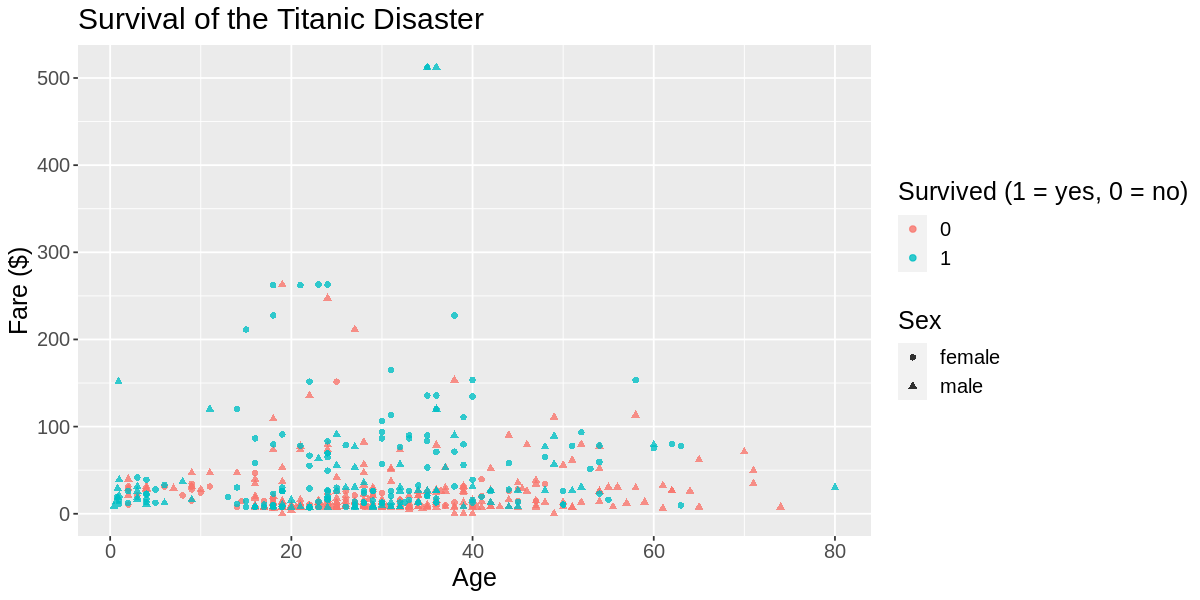

In [6]:
options(repr.plot.width=10, repr.plot.height=5)
training_plot <- ggplot(titanic_train, aes(x=Age, y=Fare)) +
geom_point(aes(color = Survived, shape = Sex), alpha=0.8) +
labs(x = "Age" , y = "Fare ($)", color = "Survived (1 = yes, 0 = no)", shape = "Sex") +
ggtitle("Survival of the Titanic Disaster") +
theme(text = element_text(size = 15))
training_plot

We can see that using a single scatter plot to try and communicate a correlation between all our data columns is very difficult to interpret. Instead, we can plot each individual factor into a bar or histogram plot to see the correlation between the factor and survival. Since `Sex` and `Pclass` are categorical, we will represent them with bar plots. Additionally, since `Age` and `Fare` are quantitative, we will represent them with histograms. For each of these visualizations, we color coded to represent the proportion of those that survived or died on the titanic. 

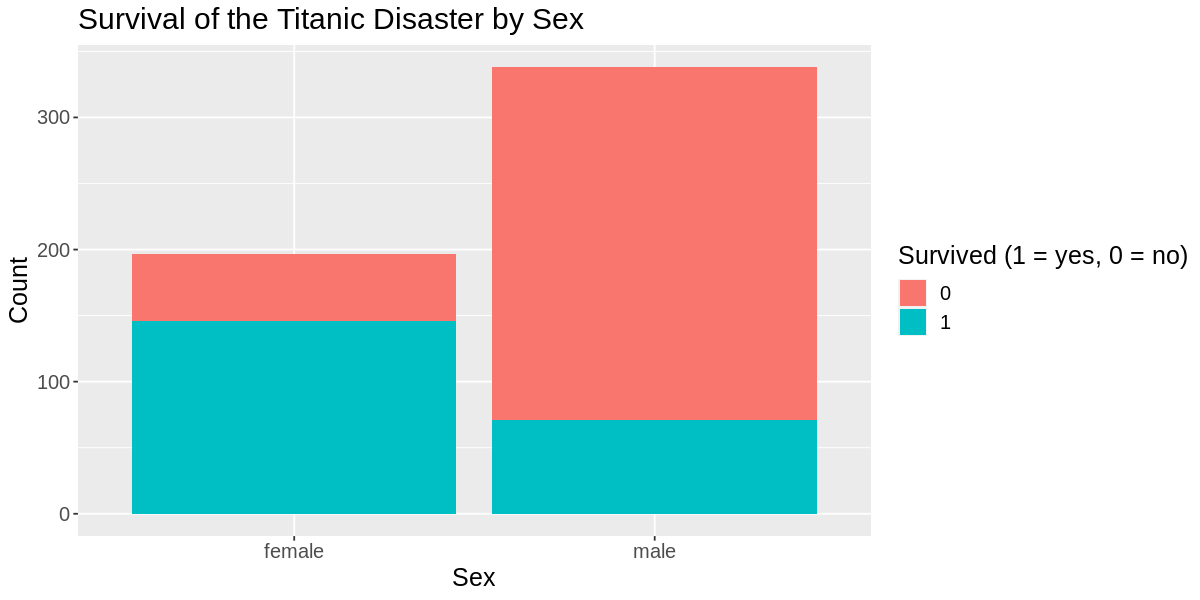

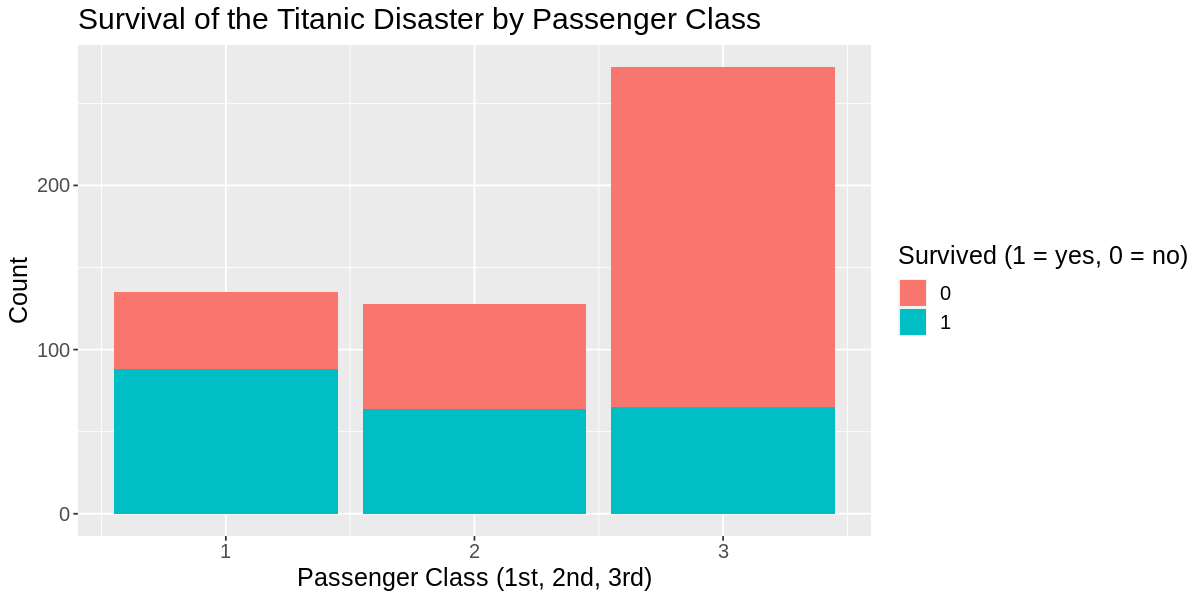

Warning message:
“Removed 4 rows containing missing values (geom_bar).”


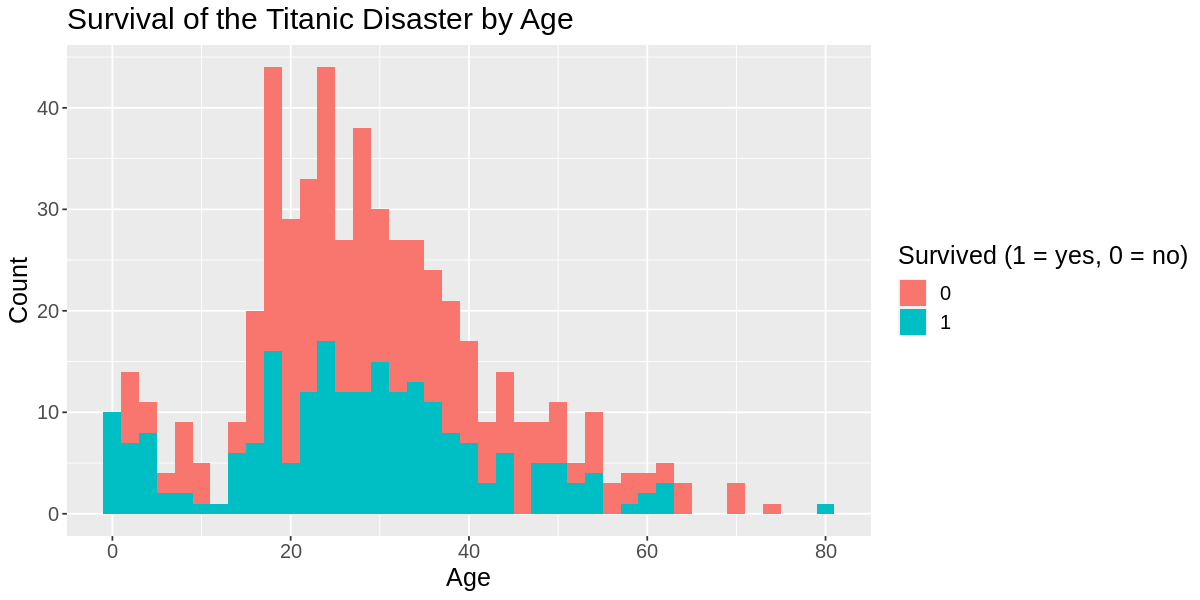

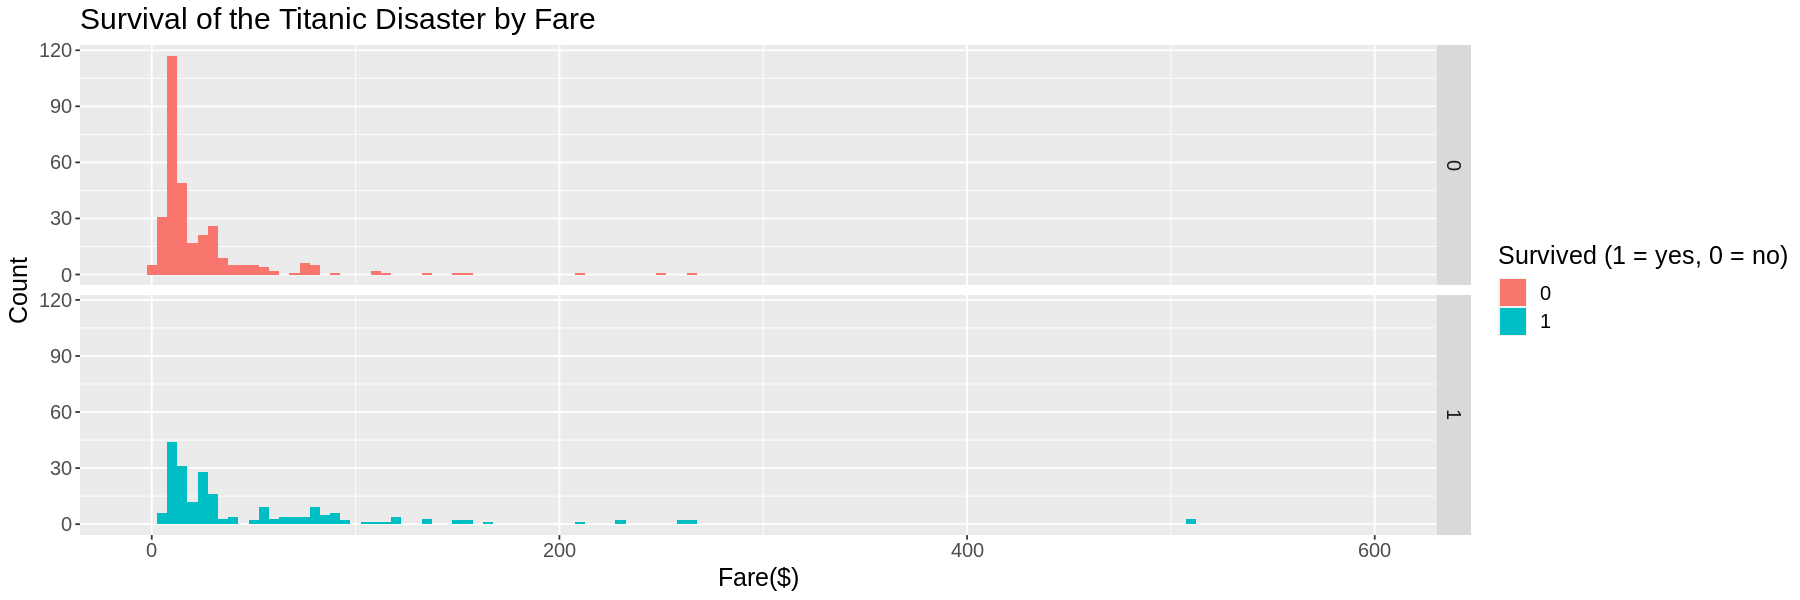

In [7]:
survived_by_sex_plot <- ggplot(titanic_train, aes(x = Sex))+
geom_bar(aes(fill = Survived)) +
labs(x = "Sex" , y = "Count", fill = "Survived (1 = yes, 0 = no)") +
ggtitle("Survival of the Titanic Disaster by Sex") +
theme(text = element_text(size = 15))
survived_by_sex_plot

survived_by_pclass_plot <- ggplot(titanic_train, aes(x = Pclass))+
geom_bar(aes(fill = Survived)) +
labs(x = "Passenger Class (1st, 2nd, 3rd)" , y = "Count", fill = "Survived (1 = yes, 0 = no)") +
ggtitle("Survival of the Titanic Disaster by Passenger Class") +
theme(text = element_text(size = 15))
survived_by_pclass_plot

survived_by_age_plot <- ggplot(titanic_train, aes(x = Age))+
geom_histogram(aes(fill = Survived), binwidth = 2) +
labs(x = "Age" , y = "Count", fill = "Survived (1 = yes, 0 = no)") +
ggtitle("Survival of the Titanic Disaster by Age") +
theme(text = element_text(size = 15))
survived_by_age_plot

options(repr.plot.width=15, repr.plot.height=5)
survived_by_fare_plot <- ggplot(titanic_train, aes(x = Fare))+
geom_histogram(aes(fill = Survived), binwidth = 5) +
labs(x = "Fare($)" , y = "Count", fill = "Survived (1 = yes, 0 = no)") +
ggtitle("Survival of the Titanic Disaster by Fare") +
facet_grid(rows = "Survived")+
xlim(-5,600)+
theme(text = element_text(size = 15))
survived_by_fare_plot

We find that the survival proportions by `Sex` and by `PClass` were clearly higher for females and those with higher passenger class, as expected. However, it is still difficult to tell for the `Age` and `Fare` plots, due to the wide range of possible values. Here, we can trust our summary table; the average age of those that survived is lower than that of those that died, and the average fare price of those that survived is much higher than those that died. Again, this is in line with what we hypothesized. Though a correlation might not be obvious in the histograms, it is fairly clear that it still exists. Therefore, we can confirm that we want to predict whether or not a titanic passenger survived based on their gender, ticket class, age, and fare price. We will further discuss our choice to keep the `Age` and `Fare` predictors in the discussion section of this report.

#### Classification:
Now that we know what we want to predict using which factors as predictors, we can begin to create our classifier. Our classifier is “good” if it can generate relatively accurate predictions on our testing data. 


The first step is to preprocess the data before we do cross-validation or train the classifier. Let’s create a new column to represent the `Sex` factor as an integer. 0 represents a female, while 1 represents a male.

In [8]:
titanic_train <- mutate(titanic_train, is_male = as.integer(Sex != 'female'))
titanic_test <- mutate(titanic_test, is_male = as.integer(Sex != 'female'))

glimpse(titanic_train)
glimpse(titanic_test)

Rows: 535
Columns: 6
$ Survived <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ Age      <dbl> 22.0, 54.0, 2.0, 20.0, 39.0, 14.0, 2.0, 35.0, 8.0, 19.0, 28.0…
$ Fare     <dbl> 7.2500, 51.8625, 21.0750, 8.0500, 31.2750, 7.8542, 29.1250, 2…
$ Sex      <fct> male, male, male, male, male, female, male, male, female, mal…
$ Pclass   <dbl> 3, 1, 3, 3, 3, 3, 3, 2, 3, 1, 1, 1, 3, 3, 3, 2, 3, 1, 3, 3, 3…
$ is_male  <int> 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1…
Rows: 179
Columns: 6
$ Survived <fct> 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0…
$ Age      <dbl> 26.0, 35.0, 27.0, 58.0, 31.0, 40.0, 66.0, 7.0, 21.0, 49.0, 21…
$ Fare     <dbl> 7.9250, 8.0500, 11.1333, 26.5500, 18.0000, 27.7208, 10.5000, …
$ Sex      <fct> female, male, female, female, female, male, male, male, male,…
$ Pclass   <dbl> 3, 3, 3, 1, 3, 1, 2, 3, 3, 1, 2, 1, 1, 2, 3, 1, 3, 2, 3, 3, 1…
$ is_male  <int> 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1

The next preprocessing step is to create the recipe, since we want to specify which columns to use as our predictors. Additionally, the K-nearest neighbors method is sensitive to the scale of the predictions, and so we need to standardize the scale and center of our predictors. 

In [9]:
titanic_recipe <- recipe(Survived ~ Age + Fare + is_male + Pclass, data = titanic_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

Additionally, we will need to tune our classifier in order to find the best value of K to be used for our classifier (the K value that will give us the highest accuracy). To do this, we will set our `neighbors` parameter of the `nearest_neighbor` function to `tune()`. 

In [10]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
neighbors = tune()) |>
set_engine("kknn") |>
set_mode("classification")

Another step that can help us choose the best K-value is cross-validation. In cross-validation our training dataset to validation sets multiple times (folds) and then evaluate their accuracies. We perform cross validation so as to ensure that our model will have the best possible estimate of accuracy. This is because if we only split our data once, it will not be the best estimate of our accuracy, as our accuracy is heavily reliant on that one split. If we only split it once, there is a chance that our validation set is lucky enough to have a perfect score on our training set, which will greatly overestimate our accuracy. For our data set we will perform a five fold cross validation to give a better estimate for our accuracy in our classifier. 

In [11]:
set.seed(2022)
titanic_vfold <- vfold_cv(titanic_train, v = 5, strata = Survived)

Then, we can compute the accuracies of all the different k-values from k=1 to k=50. Below, we first created `k_vals`, which is a data frame that contains the different k-values to try. We then pass that data frame to the `grid` parameter of the `tune_grid` function.

In [12]:
k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

# Obtaining results with various k-values
knn_results <- workflow() |>
  add_recipe(titanic_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = titanic_vfold, grid = k_vals) |>
  collect_metrics() 

# Filter to contain only the accuracies of each k-value.
accuracies <- knn_results |>
  filter(.metric == "accuracy")

# Sort k-value accuracies in descending order.
accuracies |> arrange(desc(mean))

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
3,accuracy,binary,0.8167395,5,0.008622303,Preprocessor1_Model03
4,accuracy,binary,0.8167395,5,0.008622303,Preprocessor1_Model04
5,accuracy,binary,0.8112714,5,0.006431840,Preprocessor1_Model05
⋮,⋮,⋮,⋮,⋮,⋮,⋮
28,accuracy,binary,0.7476632,5,0.007683972,Preprocessor1_Model28
25,accuracy,binary,0.7438547,5,0.009106794,Preprocessor1_Model25
26,accuracy,binary,0.7438547,5,0.009106794,Preprocessor1_Model26


From the table above, we can see that the accuracy is best at k = 3 or k = 4. However, to better visualize the difference in accuracy by different k-values, let’s create a line plot.

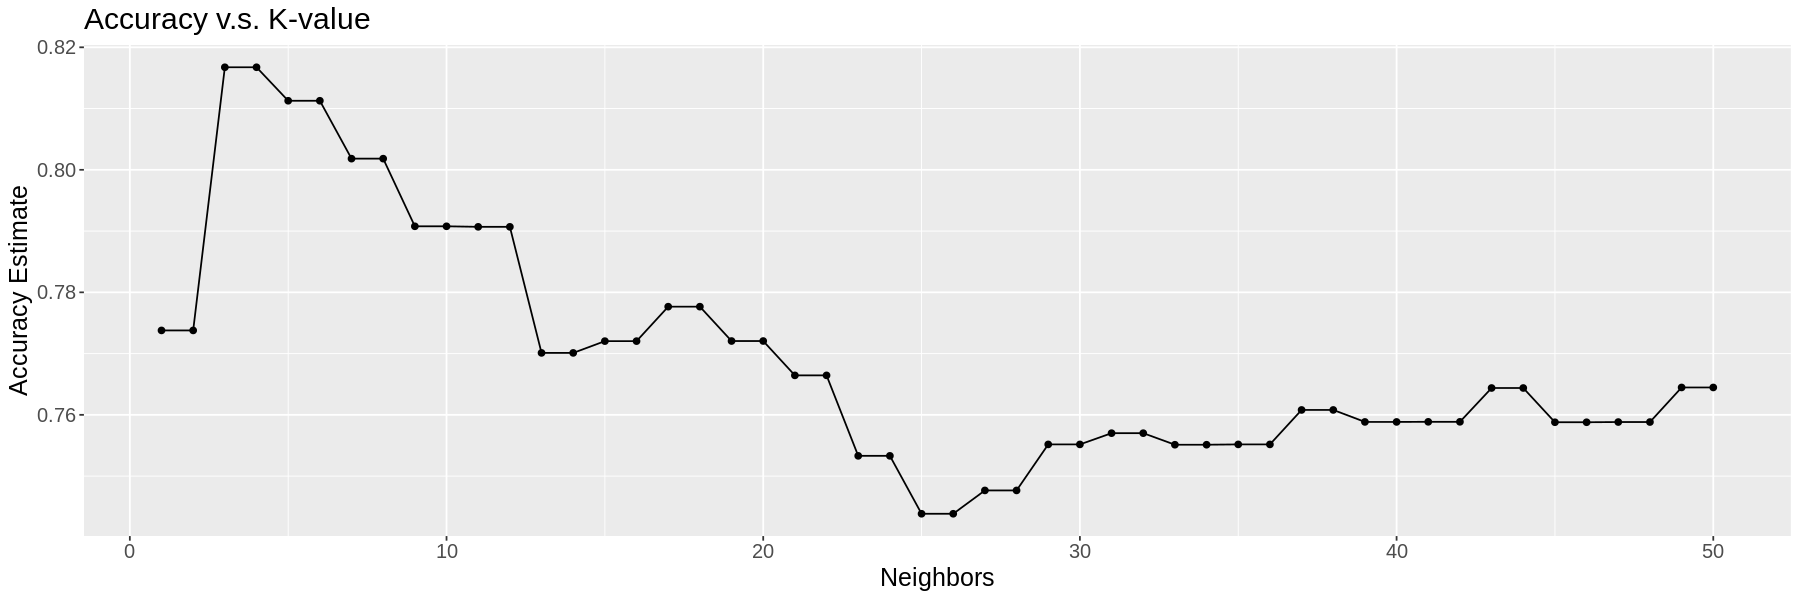

In [13]:
accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") + 
      ggtitle("Accuracy v.s. K-value") + 
    theme(text = element_text(size = 15))
accuracy_versus_k

Looking at the graph, it is clear that k = 3 or k = 4 neighbors have the highest accuracy. If we choose a higher K, our accuracy would decrease due to underfitting (each data point has a smaller influence on the prediction). On the other hand, if we choose a lower K, our accuracy would decrease due to overfitting (each data point has a bigger influence on the prediction).

Now that we know the best k-value to choose, we can create the final classifier, using a model with 3 neighbors. The recipe remains the same as the one we created to tune our classifier.

In [14]:
knn_best_k_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
      set_engine("kknn") |>
      set_mode("classification")

titanic_fit <- workflow() |>
      add_recipe(titanic_recipe) |>
      add_model(knn_best_k_spec) |>
      fit(data = titanic_train)

titanic_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(3,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1850467
Best kernel: rectangular
Best k: 3

Now, using our final fitted classifier, we can predict the survival of titanic passengers in the titanic_test data set that we set aside.

In [15]:
titanic_test_predictions <- predict(titanic_fit, titanic_test) |>
      bind_cols(titanic_test)
titanic_test_predictions

.pred_class,Survived,Age,Fare,Sex,Pclass,is_male
<fct>,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<int>
1,1,26,7.9250,female,3,0
0,0,35,8.0500,male,3,1
1,1,27,11.1333,female,3,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮
1,1,15,7.2250,female,3,0
1,1,56,83.1583,female,1,0
0,0,25,7.0500,male,3,1


Let’s plot our predictions! We want to compare the actual `Survived` values of the test set with the predictions of the test set made using our classifier. 

To visually determine the accuracy of our classifier, we can copy some of the plots we made before in order to visualize the correlation between the factor and `Survived`. Let’s start with the visual comparison of the `Sex` factor to `Survived`. The first plot contains the actual values while the second plot contains the results obtained from our classifier prediction.

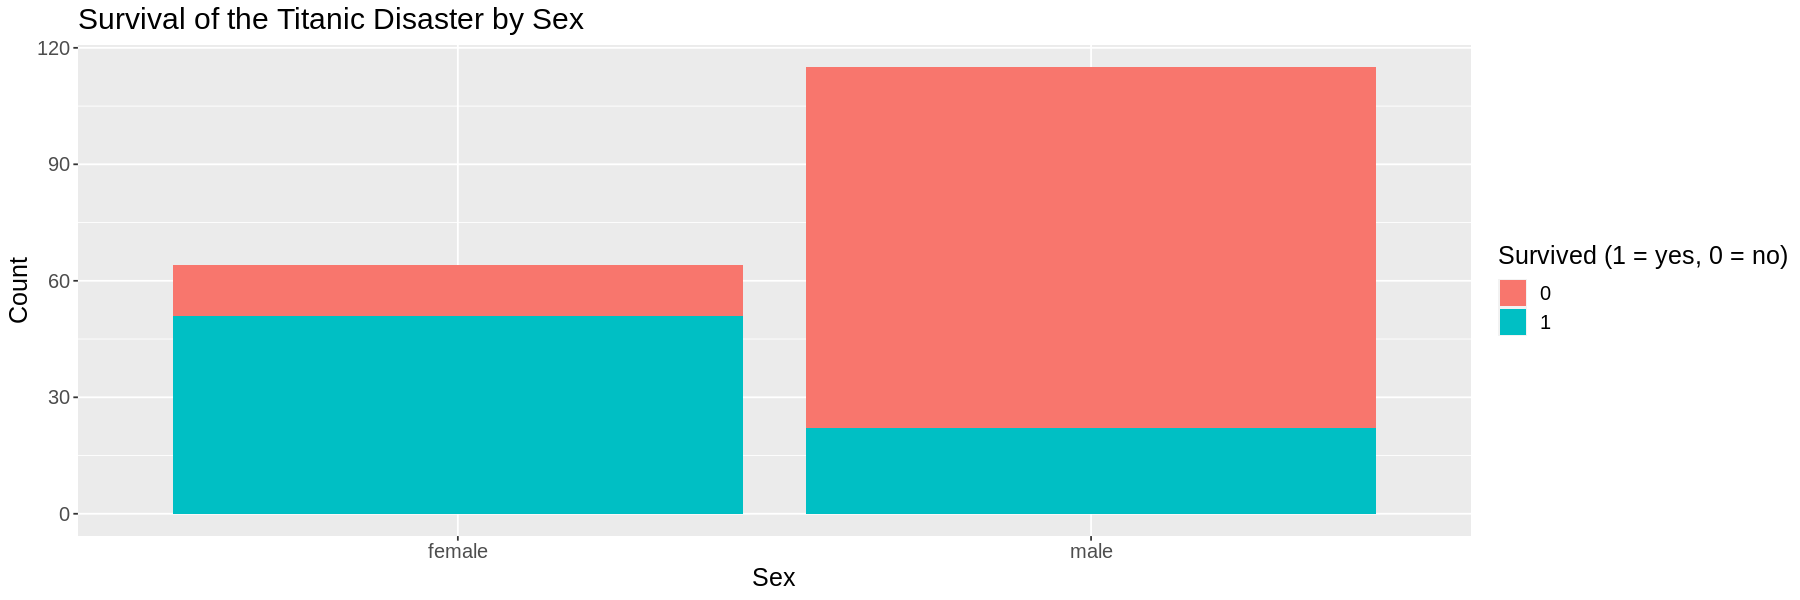

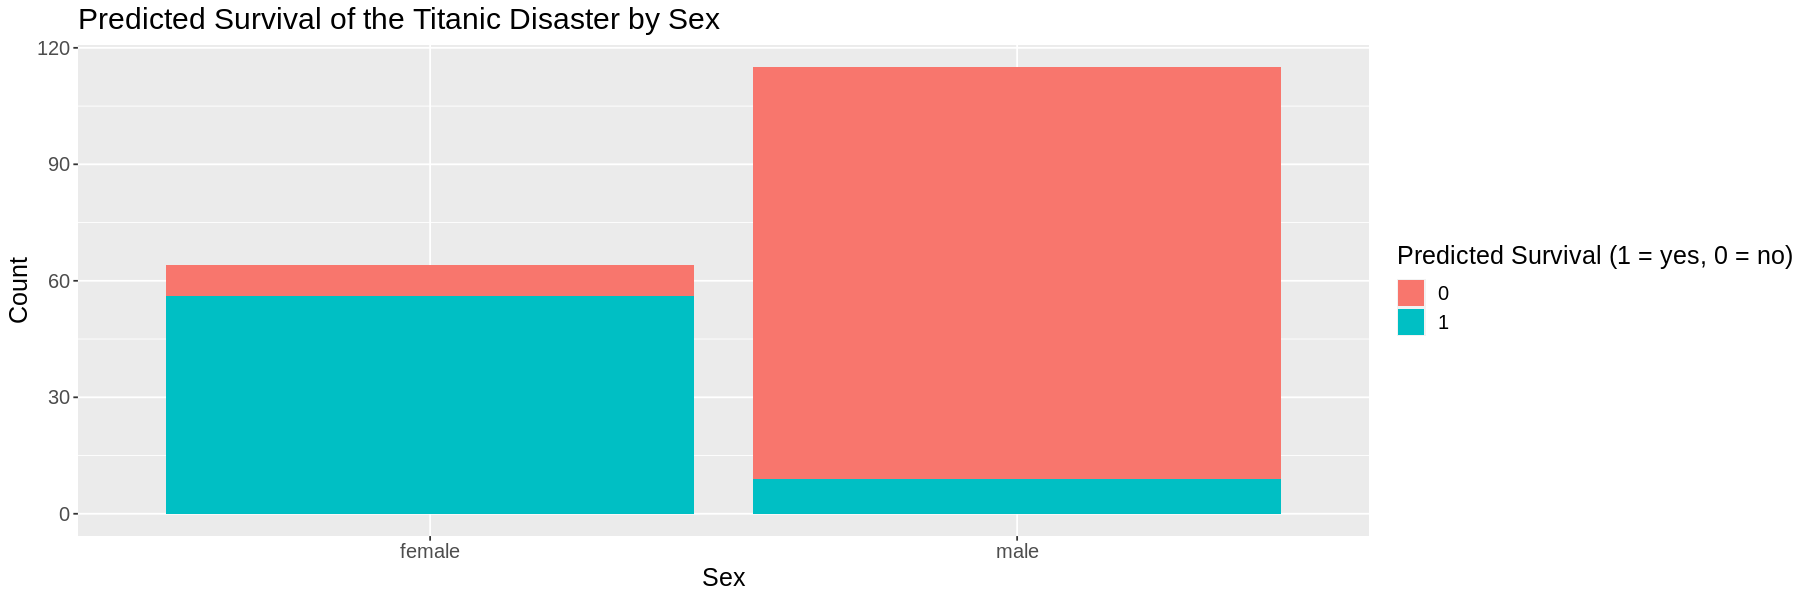

In [16]:
survived_by_sex_plot_test <- ggplot(titanic_test, aes(x = Sex))+
geom_bar(aes(fill = Survived)) +
labs(x = "Sex" , y = "Count", fill = "Survived (1 = yes, 0 = no)") +
ggtitle("Survival of the Titanic Disaster by Sex") +
theme(text = element_text(size = 15))

survived_by_sex_plot_test

pred_survived_by_sex_plot_test <- ggplot(titanic_test_predictions, aes(x = Sex))+
geom_bar(aes(fill = .pred_class)) +
labs(x = "Sex" , y = "Count", fill = "Predicted Survival (1 = yes, 0 = no)") +
ggtitle("Predicted Survival of the Titanic Disaster by Sex") +
theme(text = element_text(size = 15))

pred_survived_by_sex_plot_test

Now, let’s do the same thing, but comparing `Pclass` to `Survived` instead. Again, the first plot contains the actual values while the second plot contains the results. 

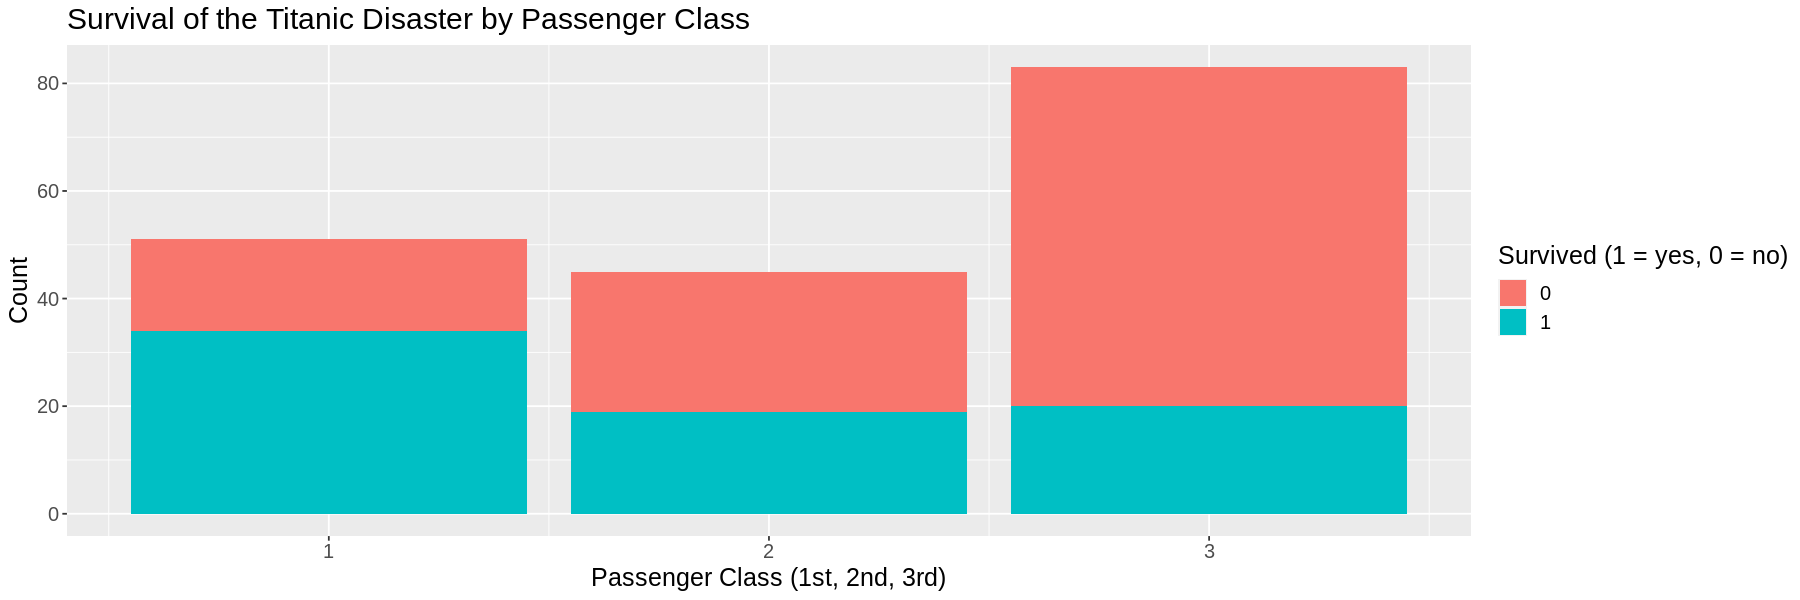

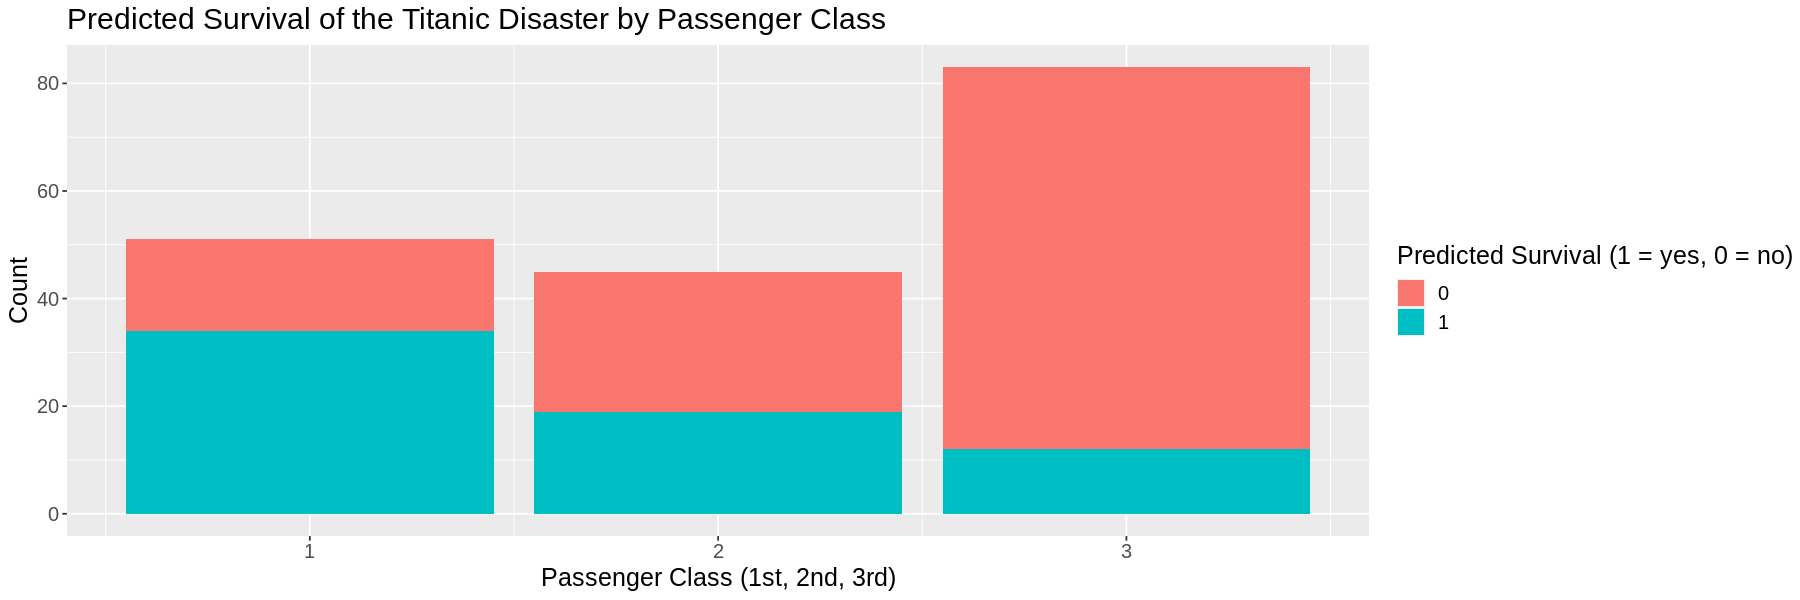

In [17]:
survived_by_pclass_plot_test <- ggplot(titanic_test, aes(x = Pclass))+
geom_bar(aes(fill = Survived)) +
labs(x = "Passenger Class (1st, 2nd, 3rd)" , y = "Count", fill = "Survived (1 = yes, 0 = no)") +
ggtitle("Survival of the Titanic Disaster by Passenger Class") +
theme(text = element_text(size = 15))

survived_by_pclass_plot_test

pred_survived_by_pclass_plot <- ggplot(titanic_test_predictions, aes(x = Pclass))+
geom_bar(aes(fill = .pred_class)) +
labs(x = "Passenger Class (1st, 2nd, 3rd)" , y = "Count", fill = "Predicted Survival (1 = yes, 0 = no)") +
ggtitle("Predicted Survival of the Titanic Disaster by Passenger Class") +
theme(text = element_text(size = 15))

pred_survived_by_pclass_plot

#### Results:

Looking at the comparison plots we generated, we can see that the actual values compared to the predicted values appear to have similar proportions. There are not any major differences between the plots that would suggest that the classifier is very inaccurate or faulty. The survival rate of women for both the actual and predicted values are greater than that of men, as expected. Additionally, in both the actual and predicted values, the survival rate of those in first class is greater than those in second class, which is greater than the survival rate of those in third class. 

Let’s also look at some numbers:

In [18]:
titanic_prediction_accuracy <- titanic_test_predictions |>
        metrics(truth = Survived, estimate = .pred_class)     
titanic_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8100559
kap,binary,0.5999211


In the metrics data frame, we observe the .metric column looking specifically at the accuracy row. Looking at the value of the .estimate variable shows that the estimated accuracy of the classifier on the test data was 81%. This value is extremely close to the accuracy estimate we got from the cross validation for k = 3 which was 81.6%. This means our model very consistently predicts with ~80% accuracy. 

In [19]:
titanic_mat <- titanic_test_predictions |> 
      conf_mat(truth = Survived, estimate = .pred_class)
titanic_mat

          Truth
Prediction  0  1
         0 93 21
         1 13 52

Observing the matrix of truth versus prediction, we can see what kind of error we were most likely to make. The prediction that the classifier gets wrong the most out of all predictions is predicting death when the passenger actually survived. This could be explained by outliers in the data in which the passenger data point was surrounded by other data points in which passengers died yet by chance this passenger survived. 

## Discussion:

From our predictions, we found that the claims about chivalry on the Titanic are true, and that women and younger people indeed had a higher rate of survival. Additionally, those that had better and more expensive tickets, that is, the wealthier people, also had a significantly higher survival rate than those of lower class. Though this is what we expected to find due to our research on the structure of the ship and the official casualty report by John Bigham, it is not entirely clear whether this was due to a difference in social standing, or due to how the ship cabins were laid out. Since first class cabins were closest to the deck, they could have simply been able to reach lifeboats first. Most likely, it is a combination of the two factors.

Although we can now classify who can survive the Titanic as a passenger, we are not able to do so for the crew, since the dataset did not contain information on the crew. If we have access to the crew members’ data, we can potentially ask the question of what can dictate a crew member’s survival, by creating a separate classifier to predict a crew member’s survival similar to what we did in this report. Additionally, we can ask the question of whether survival rates due to the predictors we used would be the same today, since modern values are different.

Another major thing to discuss is our choice to use the `Age` and `Fare` columns as predictors for our classifier. Originally, when we looked at our plots, we believed the correlations were not clear enough. However, when we compared classifiers with and without these two predictors, we found that having the predictors was far more accurate than omitting them. Though it is unclear, there is still a correlation with these predictors. Without these two predictors, our only predictors would be two categorical data types. Therefore, the classifier would not have enough to work with to create an accurate prediction.

This concludes our report on the survival of the Titanic. Thank you for reading our report!

## References:

Bigham, John. "The Loss of the Titanic, 1912". Stationery Office, 1912.

"Data Science Dojo Home". Data Science Dojo, 1 Dec. 2022, https://datasciencedojo.com/. 

Data Science Dojo. "Titanic.csv". Github Repository, 28 July 2015, https://github.com/datasciencedojo/datasets/blob/master/titanic.csv. 

Droste, Benedikt. "Machine Learning with the Titanic Dataset". Medium, 18 Jan. 2022, https://towardsdatascience.com/machine-learning-with-the-titanic-dataset-7f6909e58280.

Zhang. "The Titanic and the Passengers Who Boarded It". National Archives and Records Administration, Reagan Library, https://reagan.blogs.archives.gov/2020/05/29/the-titanic-and-the-passengers-who-boarded-it-research-and-assignment-guide/. 